# Adversarially trained autoencoder  

In part 1, we train an autoencoder using mean-squared-error (mse).  
In part 2, we couple the same autoencoder to a discriminator similar to one use for a GAN and train the autoencoder using mse on images plus binary cross entropy on the discriminator loss.  




We will train our GAN on images from CIFAR10, a dataset of 50,000 32x32 RGB images belong to 10 classes (5,000 images per class). To make 
things even easier, we will only use images belonging to the class "frog".

---
## Part 1:
Schematically, the autoencoder looks like this:

* An `encoder` network maps images of shape `(32, 32, 3)` to vectors of shape `(latent_dim,)`.
* A `decoder` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.
* An `autoencoder` network chains these together to give `ae_image = decoder(autoencoder(x))`

In part 1, this autoencoder is trained to reproduce images, using mse loss.



## The autoencoder


First,  develop an `autoencoder` model.  
* You may use any network structure that you like, **subject to a maximum of 4 million trainable parameters and a latent dimension of 32.   **
* It should input a batch of images of shape (32,32,3), funnel down to a batch of vectors 32 dimensional space, and reconstruct back to a batch of images of the same size as the original.  
* You may make separate encoder and decoder models and chain them or make a single model.  If you use separate models, you should show the summary for each plus the summary for the full model.

Use `autoencoder` as the name of your full model, and use `autoencoder.summary()` to show the structure of your autoencoder.  

The final activation should be a sigmoid to provide output values in the range 0 to 1 to create a valid image.  

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Reshape, Flatten, Dense, Conv2D, Conv2DTranspose, BatchNormalization
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

img_input = keras.Input(shape=(height, width, channels))

# Your network here to connect img_input to img_output
encoder = Sequential()
encoder.add(Conv2D(8, (7,7), activation='sigmoid', input_shape=(32,32,3)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(16, (5,5), activation='sigmoid', input_shape=(26,26,8)))
encoder.add(BatchNormalization())
encoder.add(Conv2D(32, (3,3), activation='sigmoid', input_shape=(22,22,16)))
encoder.add(BatchNormalization())
encoder.add(Flatten())
encoder.add(Dense(32, activation='sigmoid'))
encoder.add(BatchNormalization())
encoder.add(Dense(32, activation='sigmoid'))

decoder = Sequential()
decoder.add(Dense(32, activation='sigmoid'))
decoder.add(BatchNormalization())
decoder.add(Dense(20*20*32, activation='sigmoid'))
decoder.add(BatchNormalization())
decoder.add(Reshape((20,20,32)))
decoder.add(Conv2DTranspose(16, (3,3), activation='sigmoid', input_shape=(20,20,32)))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(8, (5,5), activation='sigmoid', input_shape=(22,22,16)))
decoder.add(BatchNormalization())
decoder.add(Conv2DTranspose(3, (7,7), activation='sigmoid', input_shape=(26,26,8)))

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.summary()
autoencoder.compile(optimizer='rmsprop', loss='mse')


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32)                420080    
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         483891    
Total params: 903,971
Trainable params: 878,083
Non-trainable params: 25,888
_________________________________________________________________


Here is some code to load the data and display images.

In [2]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]
x_test = x_test[y_test.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
x_test = x_test.reshape(
    (x_test.shape[0],) + (height, width, channels)).astype('float32') / 255.


import matplotlib.pyplot as plt

# input a tensor of shape (num_images, x_size, y_size, channels)
# channels is 1 for greyscale and 3 for color images
def show_images(images):
  # Display tiled images
  n_x = np.int(np.sqrt(images.shape[0]))
  n_y = np.int(np.ceil(images.shape[0]/n_x))
  tile_x = images.shape[1]
  tile_y = images.shape[2]
  figure = np.zeros((tile_x * n_x, tile_y * n_y, images.shape[3]))

  for i in range(n_x):  
    for j in range(n_y):  
      cur_ind = i+n_x*j
      if (cur_ind >= images.shape[0]):
        break
      cur_image = images[cur_ind, :,:,:]
      figure[i * tile_x: (i + 1) * tile_x,
         j * tile_y: (j + 1) * tile_y] = cur_image

  plt.figure(figsize=(n_x, n_y))
  plt.imshow(np.squeeze(figure))
  ax = plt.gca()
  ax.grid(b=None)

  plt.show()

Train your autoencoder for 100 epochs and display reconstructed and real images and training history.  ** You should be able to get validation loss below 0.02. **

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 36s 7ms/step - loss: 0.0525 - val_loss: 0.0406
Epoch 2/100
5000/5000 [==============================] - 33s 7ms/step - loss: 0.0370 - val_loss: 0.0343
Epoch 3/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0313 - val_loss: 0.0357
Epoch 4/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0283 - val_loss: 0.0320
Epoch 5/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0264 - val_loss: 0.0334
Epoch 6/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0259 - val_loss: 0.0333
Epoch 7/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0247 - val_loss: 0.0334
Epoch 8/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0243 - val_loss: 0.0263
Epoch 9/100
5000/5000 [==============================] - 34s 7ms/step - loss: 0.0236 - val_loss: 0.0289
Epoch 10/100
500

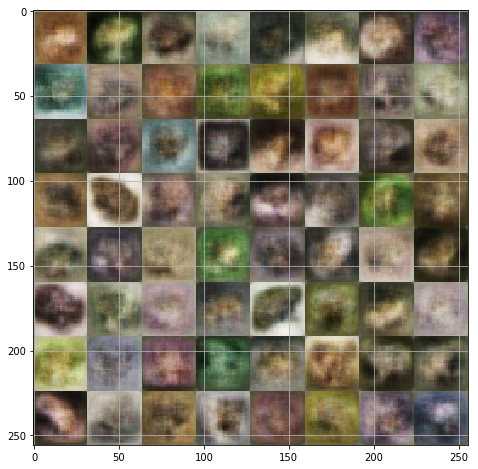

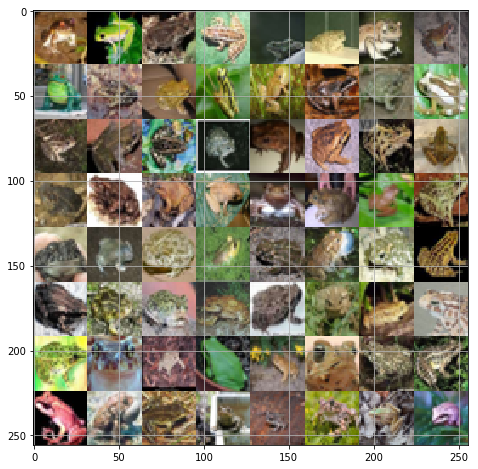

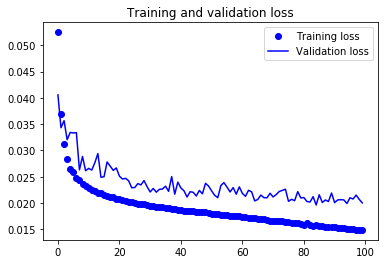

In [3]:
num_epochs = 100
history = autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

ae_images = autoencoder.predict(x_train[0:64])
show_images(ae_images)
show_images(x_train[0:64])

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()